In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

We will initialize a grid with $N \times N$ neurons in randomly assigned states $\in \{0,1\}$. The update of a neuron's state will be done according to the four neighboors' states around it using an AND gate. Furthermore, if after $\epsilon$ iterations a neuron has the same state regardless of its neighboors, they form an ensemble, which will have update rules as a unit. As such, if $\Phi \geq \epsilon$, an ensemble is formed.

In [2]:
def AND(inputs):
    return np.all(inputs == 1, axis=0).astype(int)

def OR(inputs):
    return np.any(inputs == 1, axis=0).astype(int)

def NAND(inputs):
    return 1 - AND(inputs)

def NOR(inputs):
    return 1 - OR(inputs)

def XOR(inputs):
    return (np.sum(inputs, axis=0) % 2).astype(int)
    
def XNOR(inputs):
    return 1 - XOR(inputs)

def Tautology(inputs):
    return np.ones((inputs.shape[1], inputs.shape[1]), dtype=int)  # Return 1 for all outputs

def Contradiction(inputs):
    return np.zeros((inputs.shape[1], inputs.shape[1]), dtype=int)  # Return 0 for all outputs

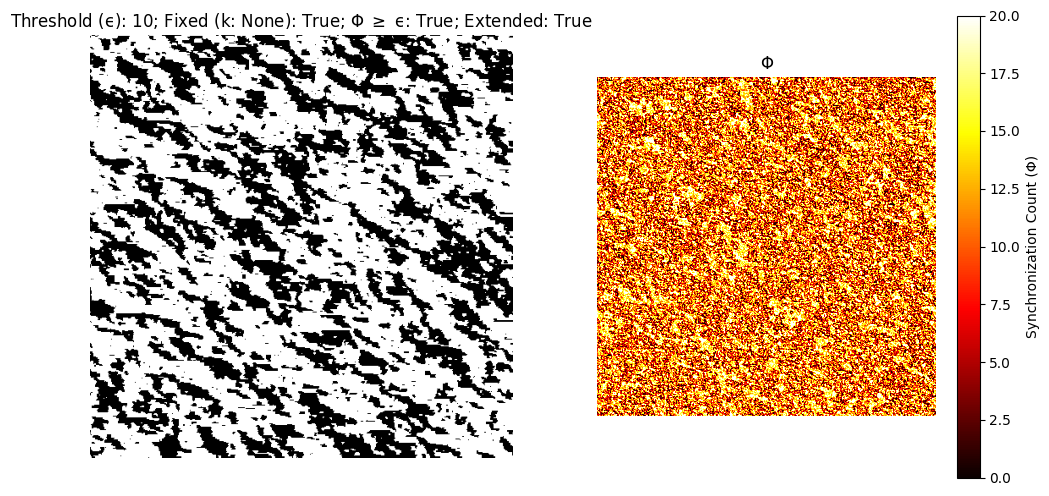

In [11]:
N = 500 #neuron count -> N² neurons generated
iter = 20 #number of iterations
S = np.random.choice((0,1), size = (N, N))
#ϵ = 1 #threshold -> affects emergent dynamics(?)
fix = True #to have ϵ fixed
k = 6 #If not fixed -> used denominator -> At max ϵ -> iter/k
ϵ_fixed = 10
Φ = np.zeros((N, N), dtype=int) #To keep track of synchronization at each neuron/ensemble
extended = True #Considering also diagonal neighboors

"""
compare condition between Φ and ϵ
If True -> Ensemble when Φ >= ϵ
If False -> Ensemble when Φ == ϵ
"""
geq_cond = True 

#Compute entropy of the net
def H(S):
    counts = np.unique(S, return_counts=True)[1]
    p = counts/(N**2)
    return -np.sum(p * np.log(p))

def dynamics(*args, fixed = False):
    if fixed: #fixed assignment of ϵ
        return ϵ_fixed
    else:
        return int((iter * (1 - H(S)))/k)
        
ϵ = dynamics(fixed = fix)

gates = [AND, OR, XOR] #more interesting behaviour without neg gates


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mat1 = ax1.imshow(S, cmap="gray", vmin=0, vmax=1)
mat2 = ax2.imshow(Φ, cmap="hot", vmin=0, vmax=iter)
ax1.set_title(f"Threshold (ϵ): {ϵ}")
ax1.axis("off")
ax2.set_title("Φ")
ax2.axis("off")
cbar2 = fig.colorbar(mat2, ax=ax2)
cbar2.set_label("Synchronization Count (Φ)")

gate = np.random.choice(gates, (N, N))
def update(*args):
    global S, Φ, ϵ
    #choose a gate randomly for each iter
    #gate = np.random.choice(gates) 
    #Getting neighboors by shifting matrix
    left = np.roll(S, -1, axis = 1)
    right = np.roll(S, 1, axis = 1)
    up = np.roll(S, 1, axis = 0)
    down = np.roll(S, -1, axis = 0)

    # stack neighboor states
    neighboors = np.stack([left, right, up, down], axis = 0)

    #return new state
    new_state = np.array([[gate[i, j](neighboors[:, i, j]) for j in range(N)] for i in range(N)])

    sync = (new_state == S)
    Φ[sync] += 1 
    Φ[~sync] = 0

    if geq_cond:
        mask_ensemble = (Φ >= ϵ)
    else:
        mask_ensemble = (Φ == ϵ)
    ϵ = dynamics(fixed = fix)
    S = new_state #update state
    # update given any ensemble formation
    if np.any(mask_ensemble):
        ensemble_idxs = np.argwhere(mask_ensemble)
        for i, j in ensemble_idxs:
            if extended:
                S[(i-1) % N, (j-1) % N] = S[i, j]  #upper left 
                S[(i-1) % N, (j+1) % N] = S[i, j]  #upper right 
                S[(i+1) % N, (j+1) % N] = S[i, j]  #bottom right 
                S[(i+1) % N, (j-1) % N] = S[i, j]  #bottom left
                S[i, (j-1) % N] = S[i, j]  #left 
                S[i, (j+1) % N] = S[i, j]  #right 
                S[(i-1) % N, j] = S[i, j]  #up 
                S[(i+1) % N, j] = S[i, j]  #down 
                
            else:
                #update neighboors given central neuron forming ensemble
                S[i, (j-1) % N] = S[i, j]  #left 
                S[i, (j+1) % N] = S[i, j]  #right 
                S[(i-1) % N, j] = S[i, j]  #up 
                S[(i+1) % N, j] = S[i, j]  #down 
    mat1.set_array(S)
    mat2.set_array(Φ)

    ax1.set_title(f"Threshold (ϵ): {ϵ}; Fixed (k: {k if not fix else None}): {fix}; Φ $\geq$ ϵ: {geq_cond}; Extended: {extended}")
    return mat1, mat2

ani = FuncAnimation(fig, update, frames=iter, interval=1000)
ani.save("autopoietic_net.gif", writer="pillow", fps=10)

plt.show()